In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.cluster.hierarchy import dendrogram
import plotly.graph_objects as go

from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import SimpleImputer, IterativeImputer

import random

from unidecode import unidecode

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from listes import *

In [2]:
from mydataviz import *

# Initialisation
## Chargement du dataset

In [3]:
# Chargement du dataset complet (317661, 28)
#data = pd.read_csv('./data/data_clean.csv', low_memory=False)

In [4]:
# Création d'un extrait du dataset pour charger et expérimenter plus rapidement
#data_petit = data.iloc[np.random.randint(0, len(data), 50000)]
#data_petit.to_csv("./data/data_clean_petit.csv")

In [5]:
# Chargement du dataset version réduite (50000 valeurs pour les tests)
data = pd.read_csv("./data/data_clean_petit.csv", low_memory=False)

## Mise en forme initiale

In [6]:
# Suppression de valeurs abérantes qui nuisent aux graphiques
data.loc[data['carbohydrates_100g']<0] = 0
data.loc[data['fat_100g']<0] = 0

In [7]:
# Et des restes de colonnes d'index
for c in ['Unnamed: 0.1', 'Unnamed: 0']:
    if c in data.columns:
        data = data.drop(c, axis=1)

## Création de quelques variables utiles

In [8]:
# Création de la liste des colonnes numeriques
listeColFloat = data.select_dtypes(exclude='object').columns.tolist()
if 'code' in listeColFloat : listeColFloat.remove('code')

In [9]:
# Dictionnaire de traduction des noms de colonnes
nomColonnes = {'fat_100g':'Lipides', 'saturated-fat_100g':'Graisses saturées', 'energy_100g':'Energie',
              'carbohydrates_100g':'Glucides', 'sugars_100g':'Sucres', 'proteins_100g':'Protéines',
              'nutrition-score-fr_100g':'Nutriscore', 'omega-3-fat_100g':'Omega3', 'fiber_100g':'Fibres',
              'salt_100g':'Sel', 'sodium_100g':'Sodium', 'fruits-vegetables-nuts_100g':'Fruits, legumes et noix',
              'additives_n':"Nombre d'additifs", 'ingredients_from_palm_oil_n':"Nombre d'ingrédients palmiques",
              'ingredients_that_may_be_from_palm_oil_n':"Nombre d'ingrédients possiblement palmiques",
              'nutrition_grade_fr':'Classement Nutriscore', 'categories':'Catégorie'}

In [10]:
# Liste de toutes les catégories par ordre d'importance/remplissage décroissant
listeCatRemplissage = data['categories'].value_counts()

# Exploration des données

## Exploration générale

In [11]:
print("Fichier de dimension " + str(data.shape) + " :\n")

print("\n\nType des colonnes :")
print(data.dtypes.to_markdown())

print("\n\nTaux de remplissage (%) :")
print(((1- data.isna().mean())*100).to_markdown())

print("\n\nNombre de valeurs uniques par colones :")
print(data.nunique().to_markdown())

Fichier de dimension (317661, 27) :



Type des colonnes :
|                                            | 0       |
|:-------------------------------------------|:--------|
| code                                       | int64   |
| product_name                               | object  |
| image_url                                  | object  |
| categories                                 | object  |
| ingredients_text                           | object  |
| additives_n                                | float64 |
| additives                                  | object  |
| additives_tags                             | object  |
| ingredients_from_palm_oil_n                | float64 |
| ingredients_from_palm_oil_tags             | object  |
| ingredients_that_may_be_from_palm_oil_n    | float64 |
| ingredients_that_may_be_from_palm_oil_tags | object  |
| nutrition_grade_fr                         | object  |
| energy_100g                                | float64 |
| fat_100g                   

## Analyse des valeurs nulls

<AxesSubplot: >

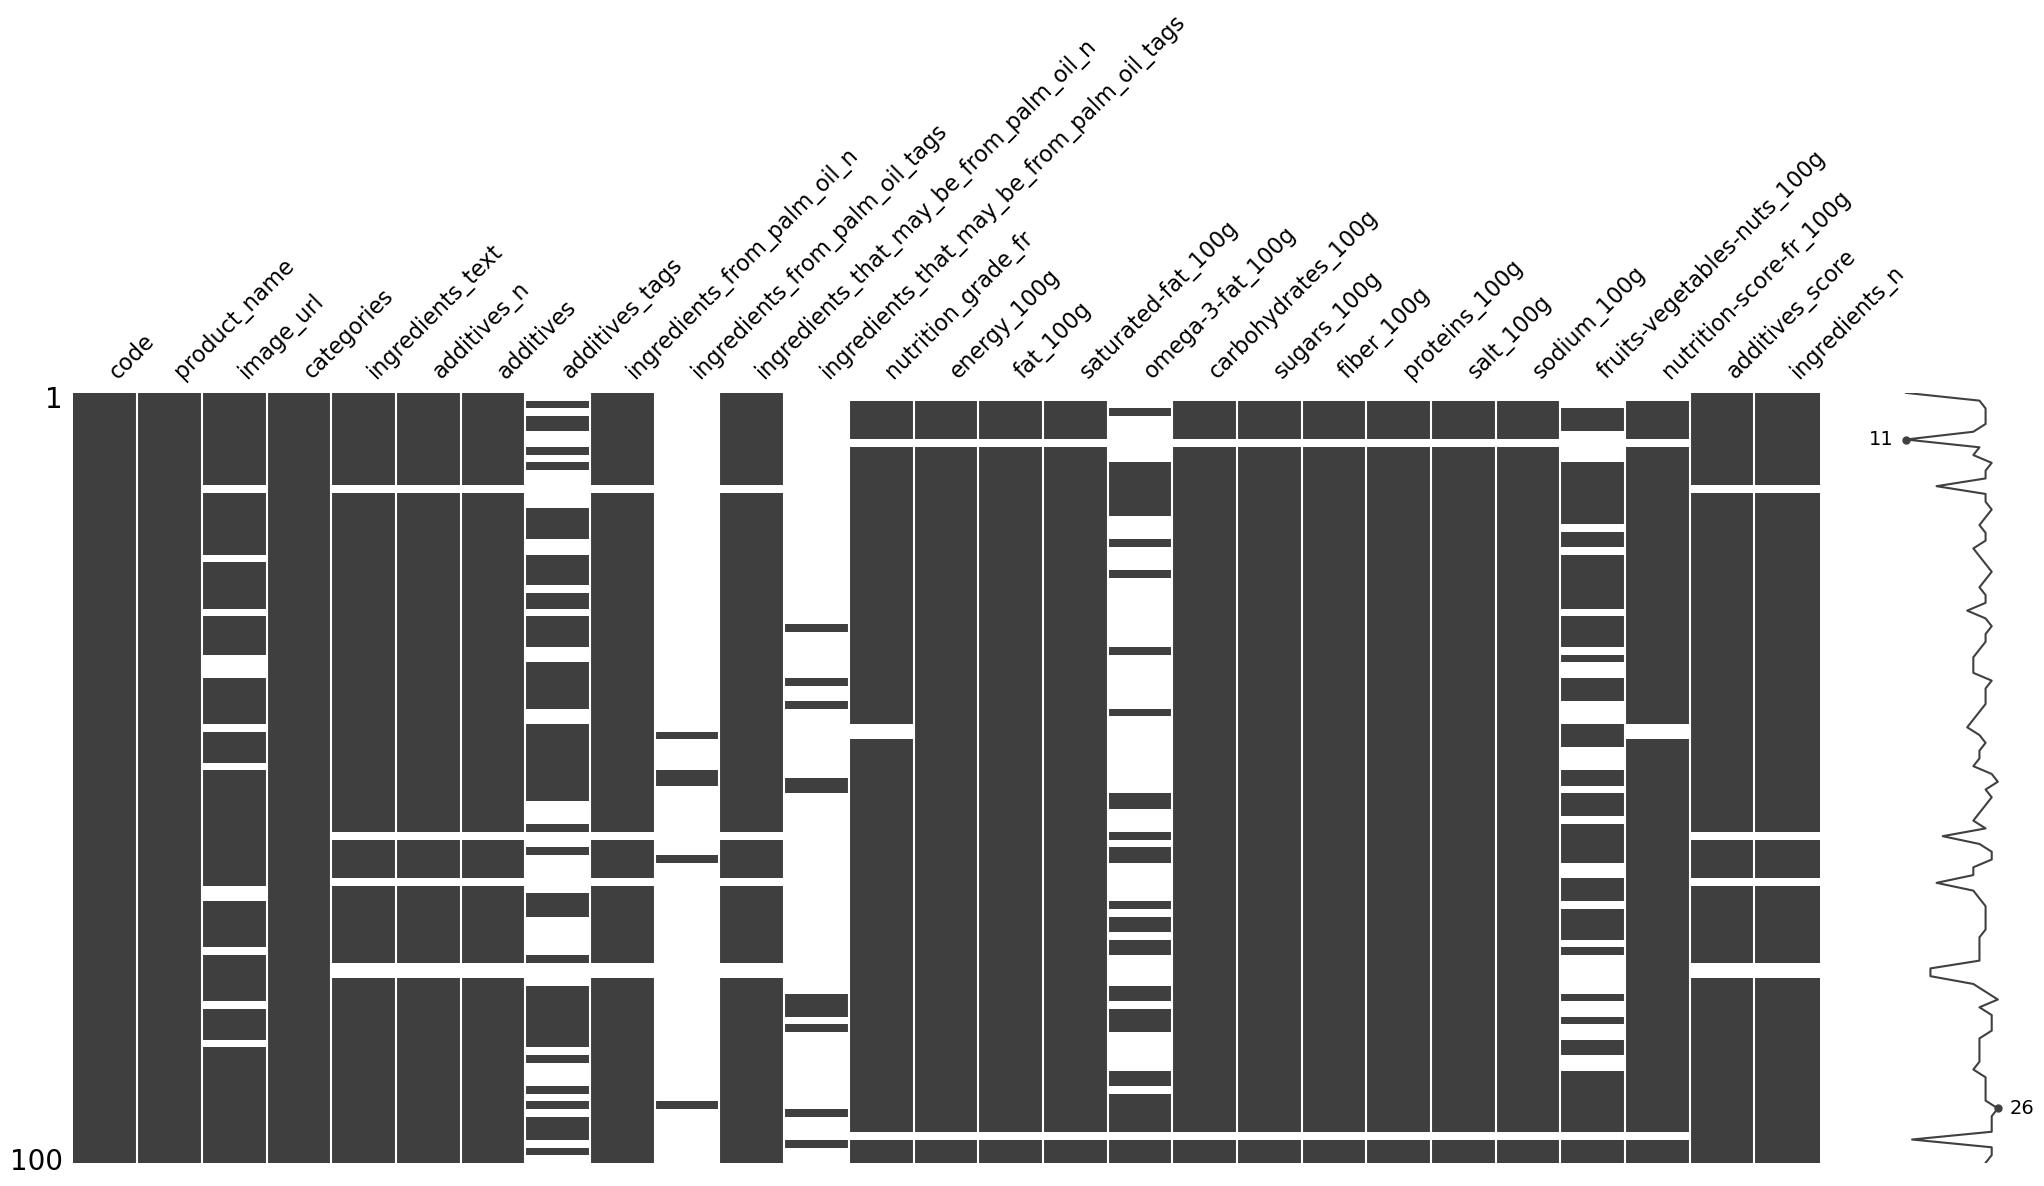

In [12]:
msno.matrix(data[:100])

<AxesSubplot: >

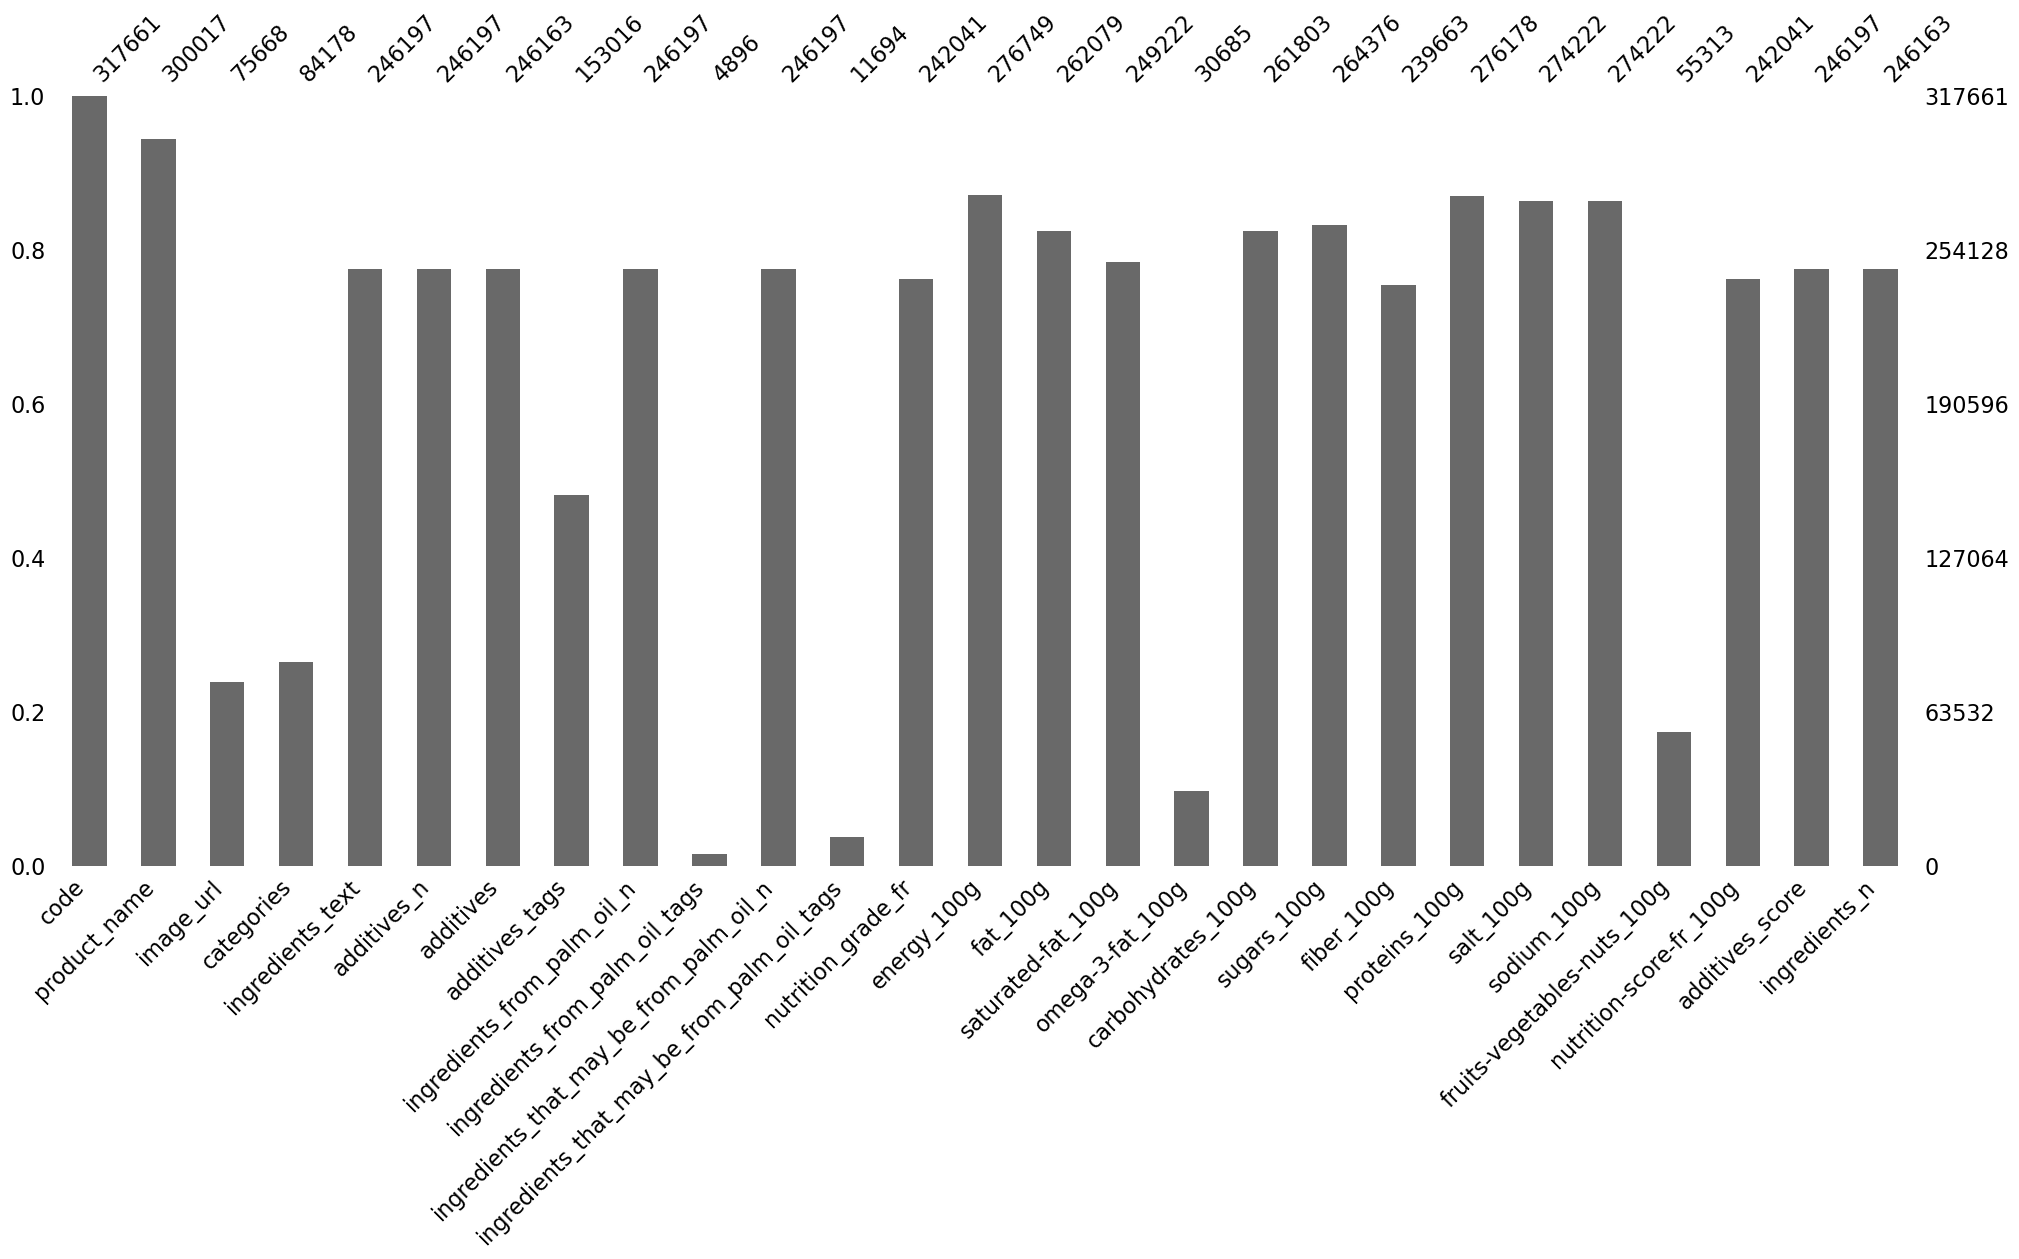

In [13]:
msno.bar(data)

<AxesSubplot: >

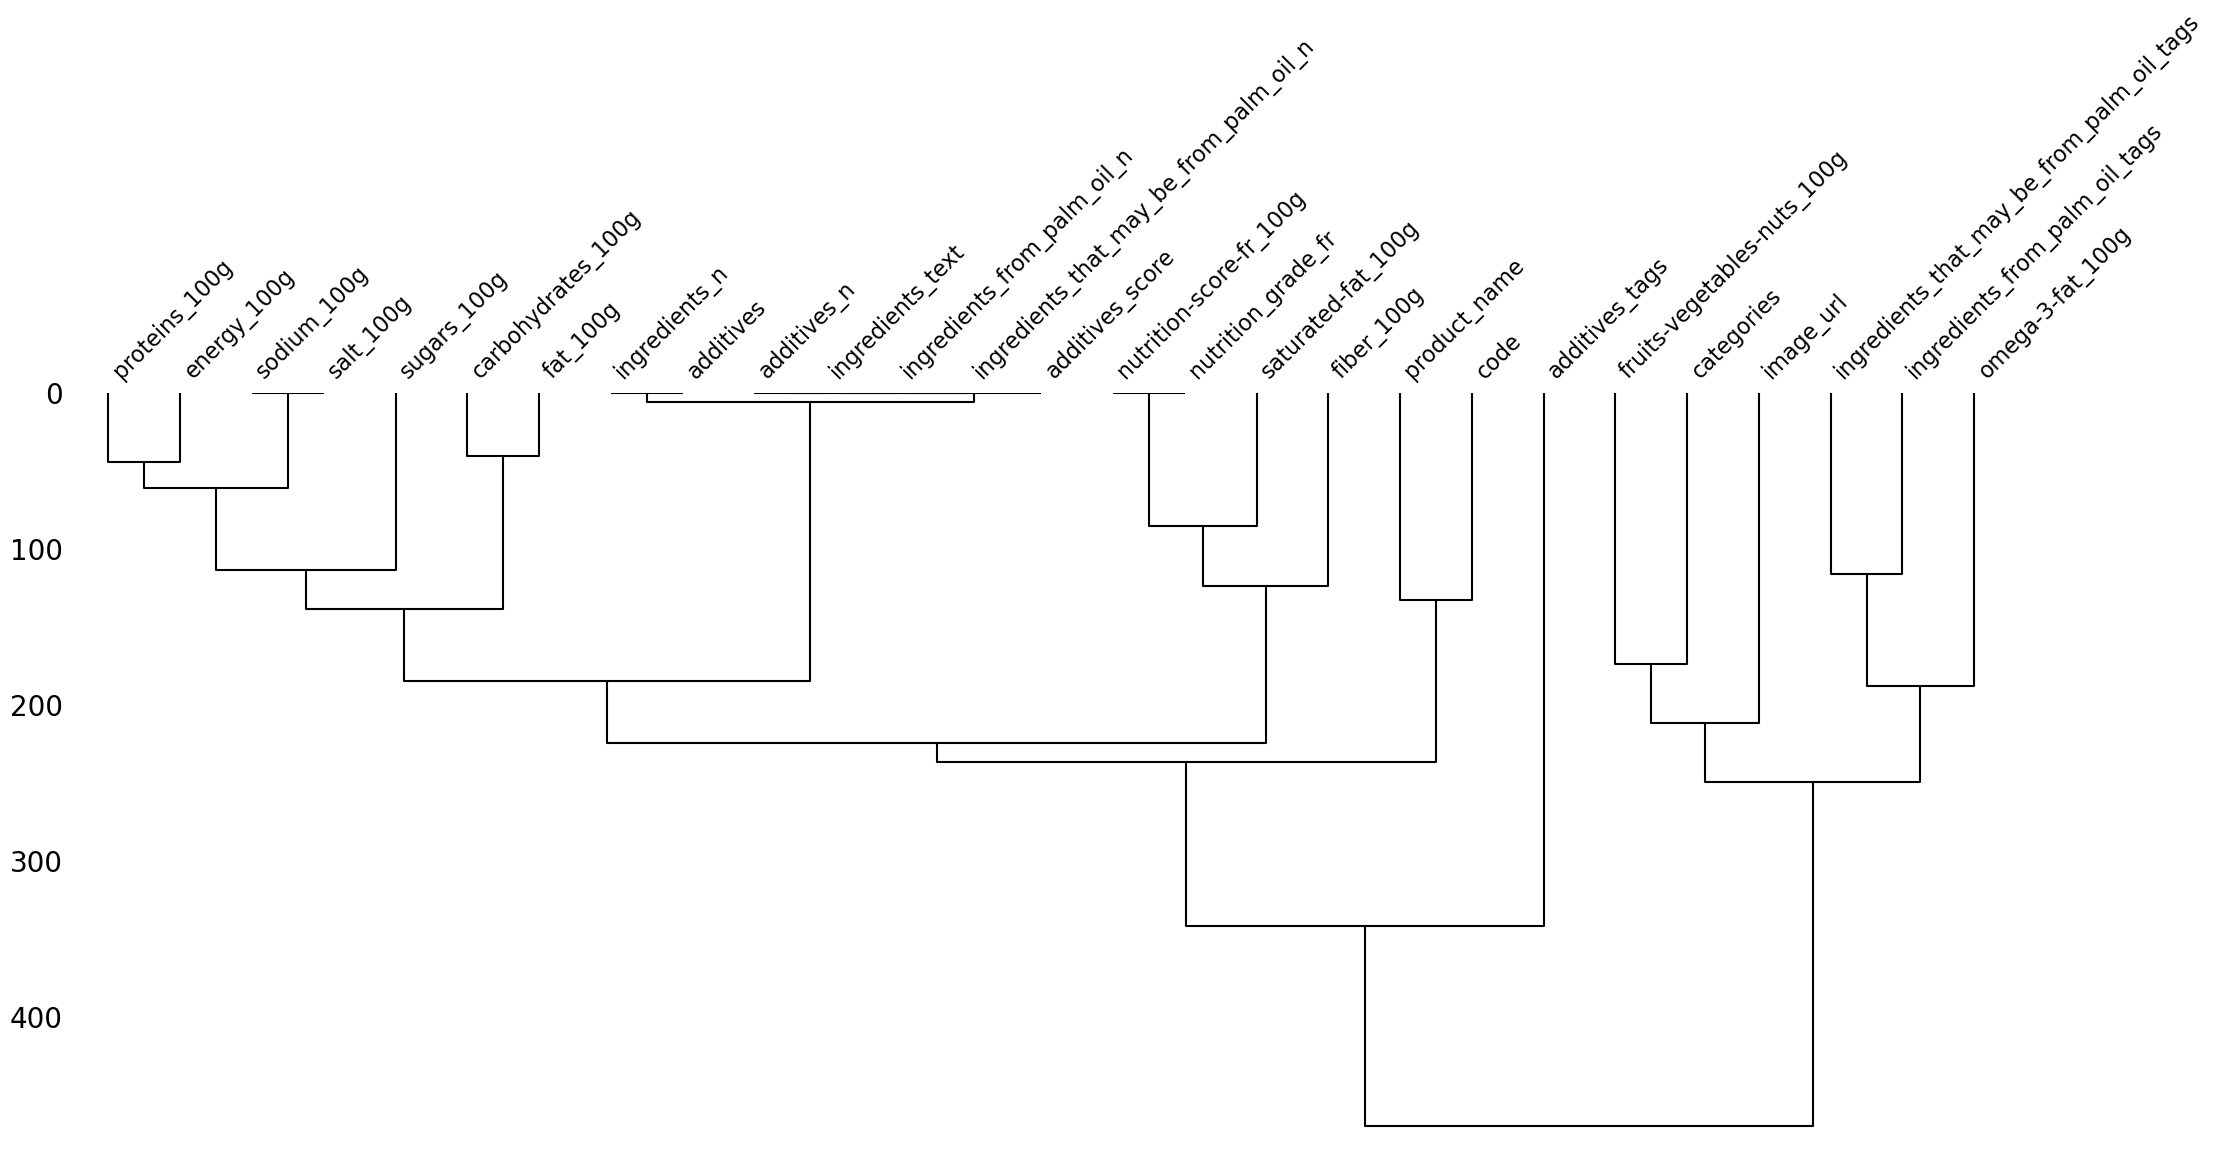

In [14]:
msno.dendrogram(data)

<AxesSubplot: >

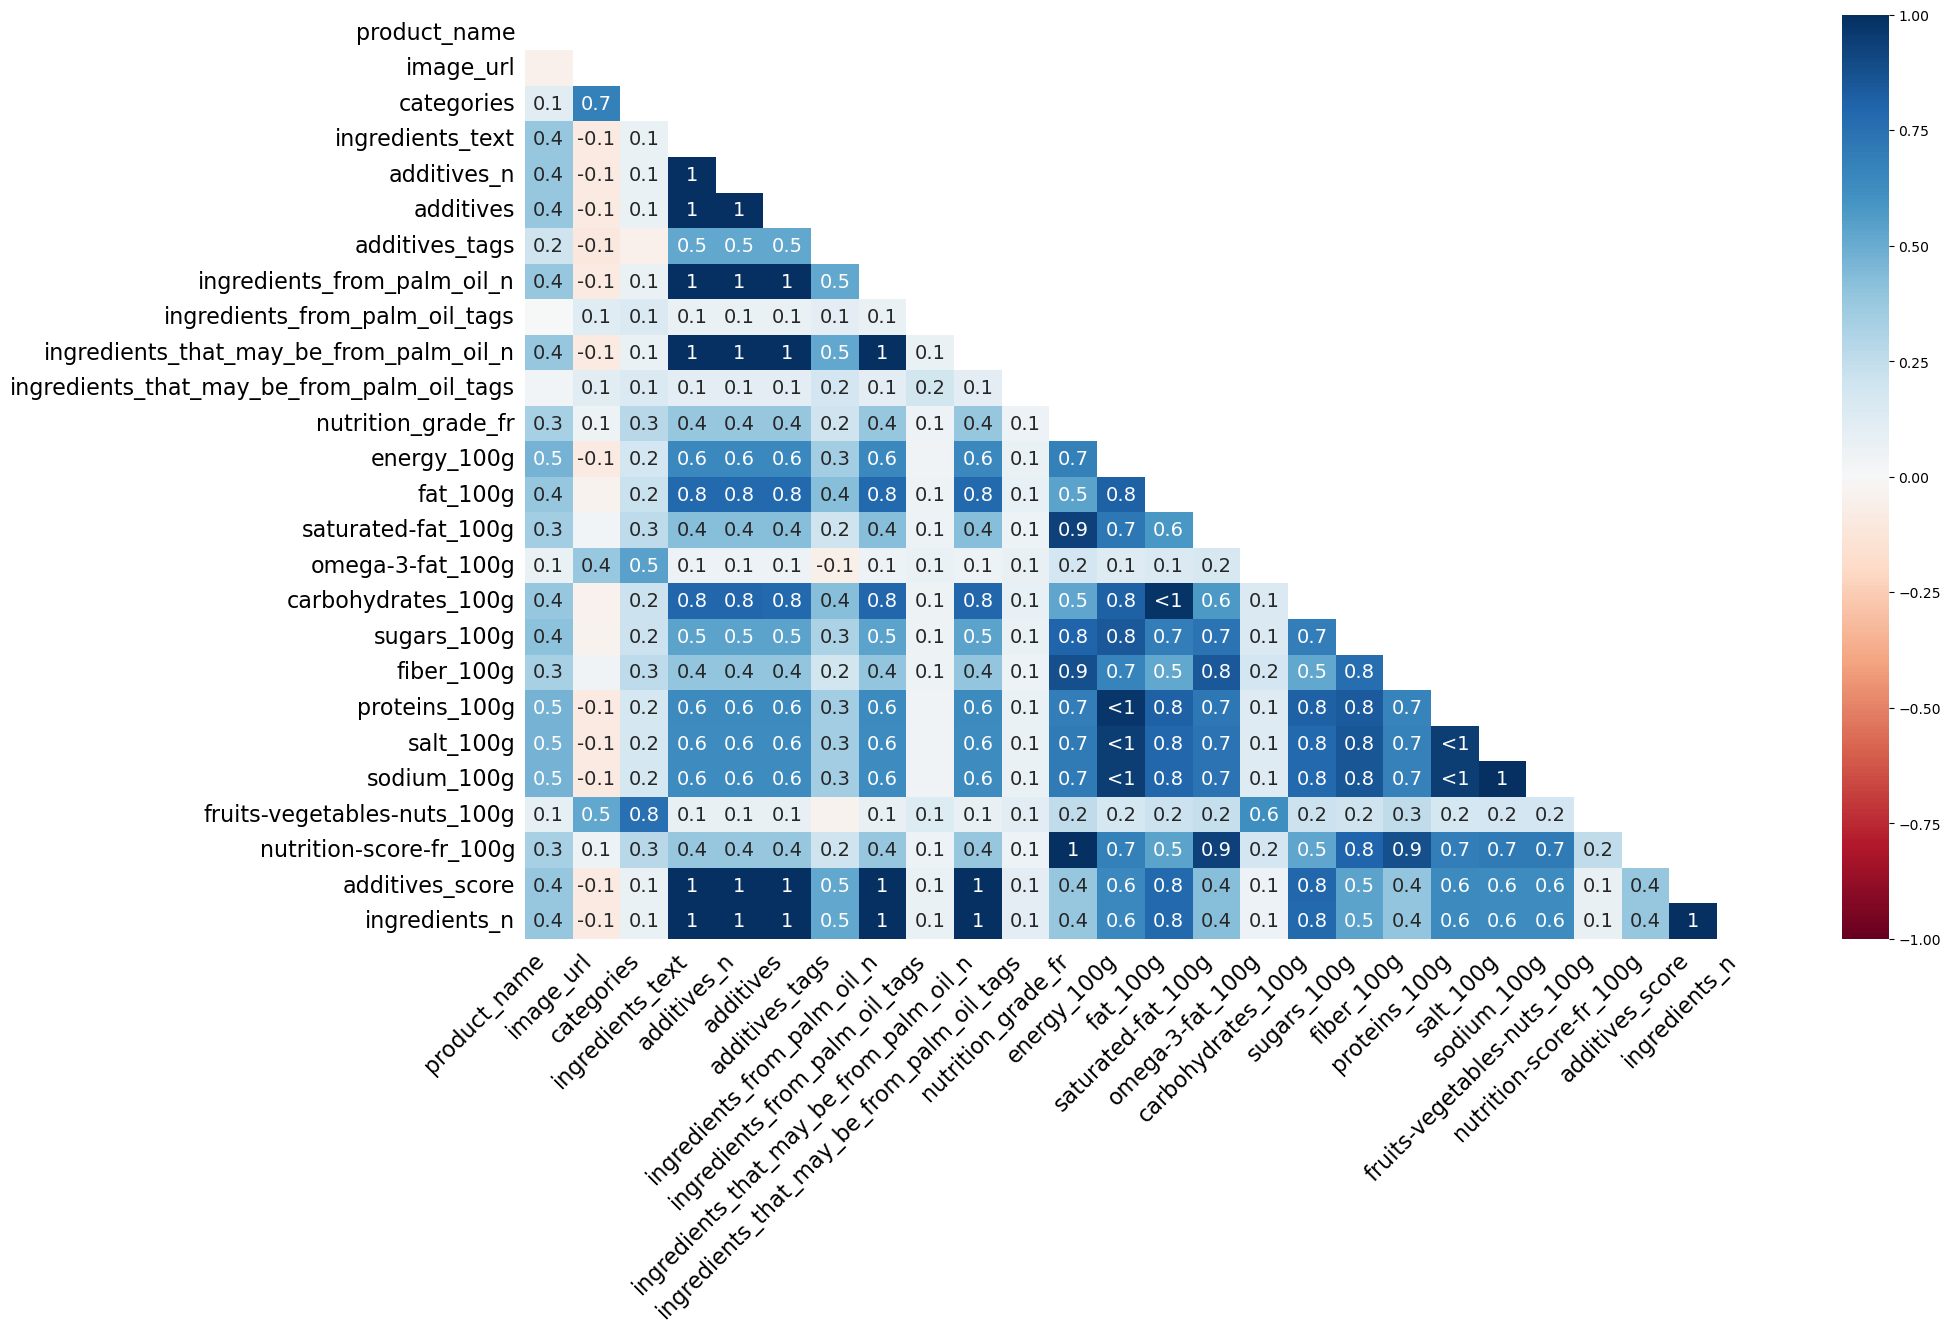

In [15]:
msno.heatmap(data)

## Analyse univarié

### Variables textuelles observées avec des nuages de mots

In [16]:
# Concatenation de tous les noms de produit pour faire une unique variable texte
txt = ' '.join(data['product_name'].astype(str).fillna(''))

In [17]:
tmp = DataSet.make_dataset(txt, 'txt')

In [18]:
wc = tmp.normalise().wordcloud(stopwords=STOPWORDS, width=900, height=600, max_font_size=120, background_color="white")

In [19]:
sns.set(rc={"figure.figsize":(18, 12)})

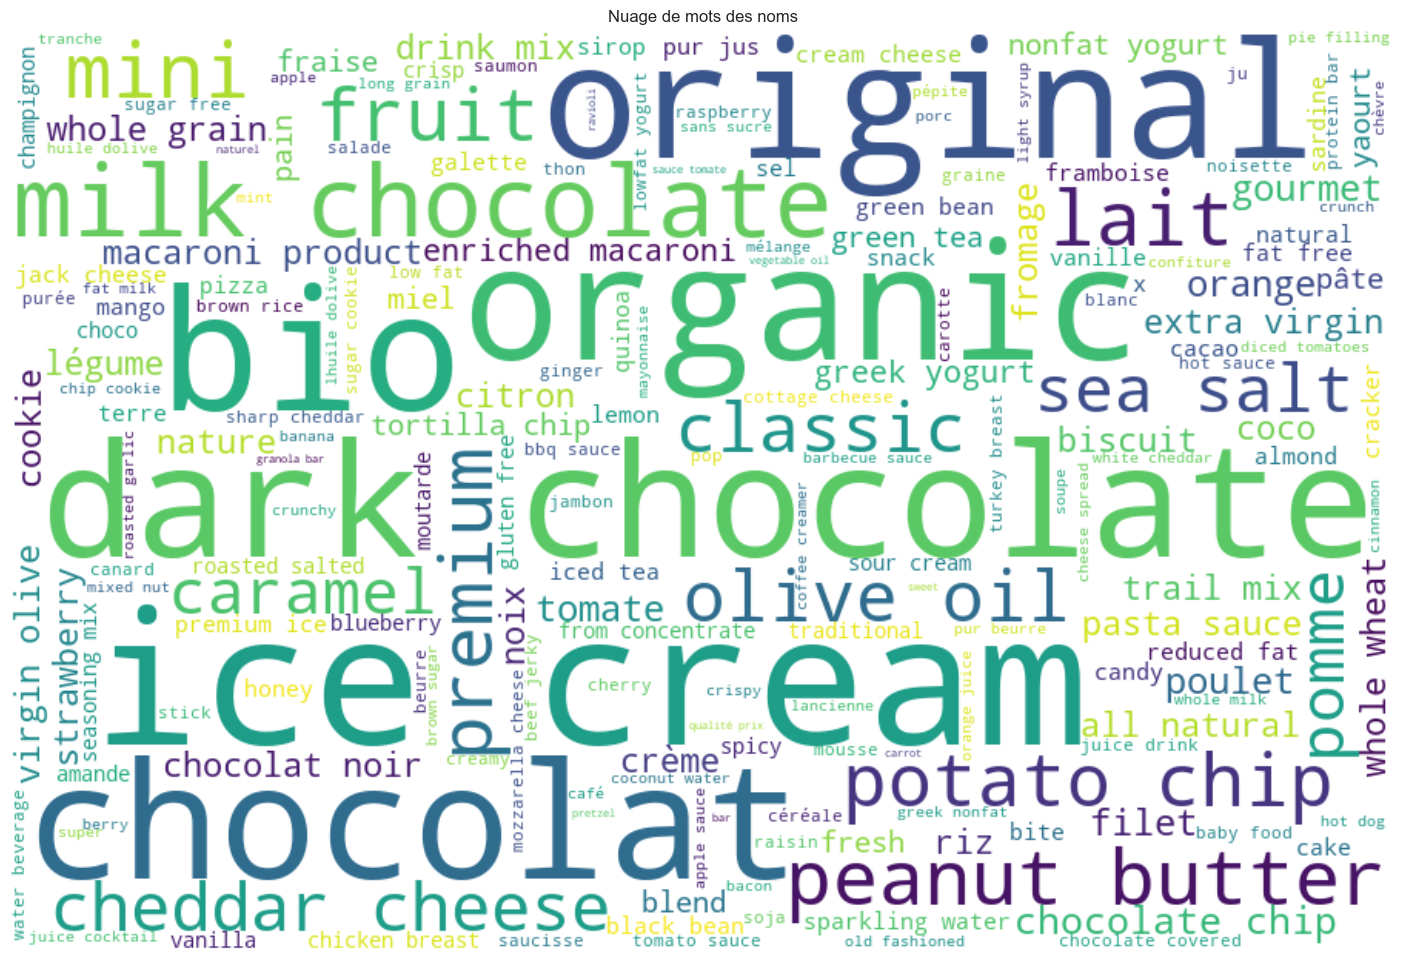

In [20]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots des noms")
plt.show()

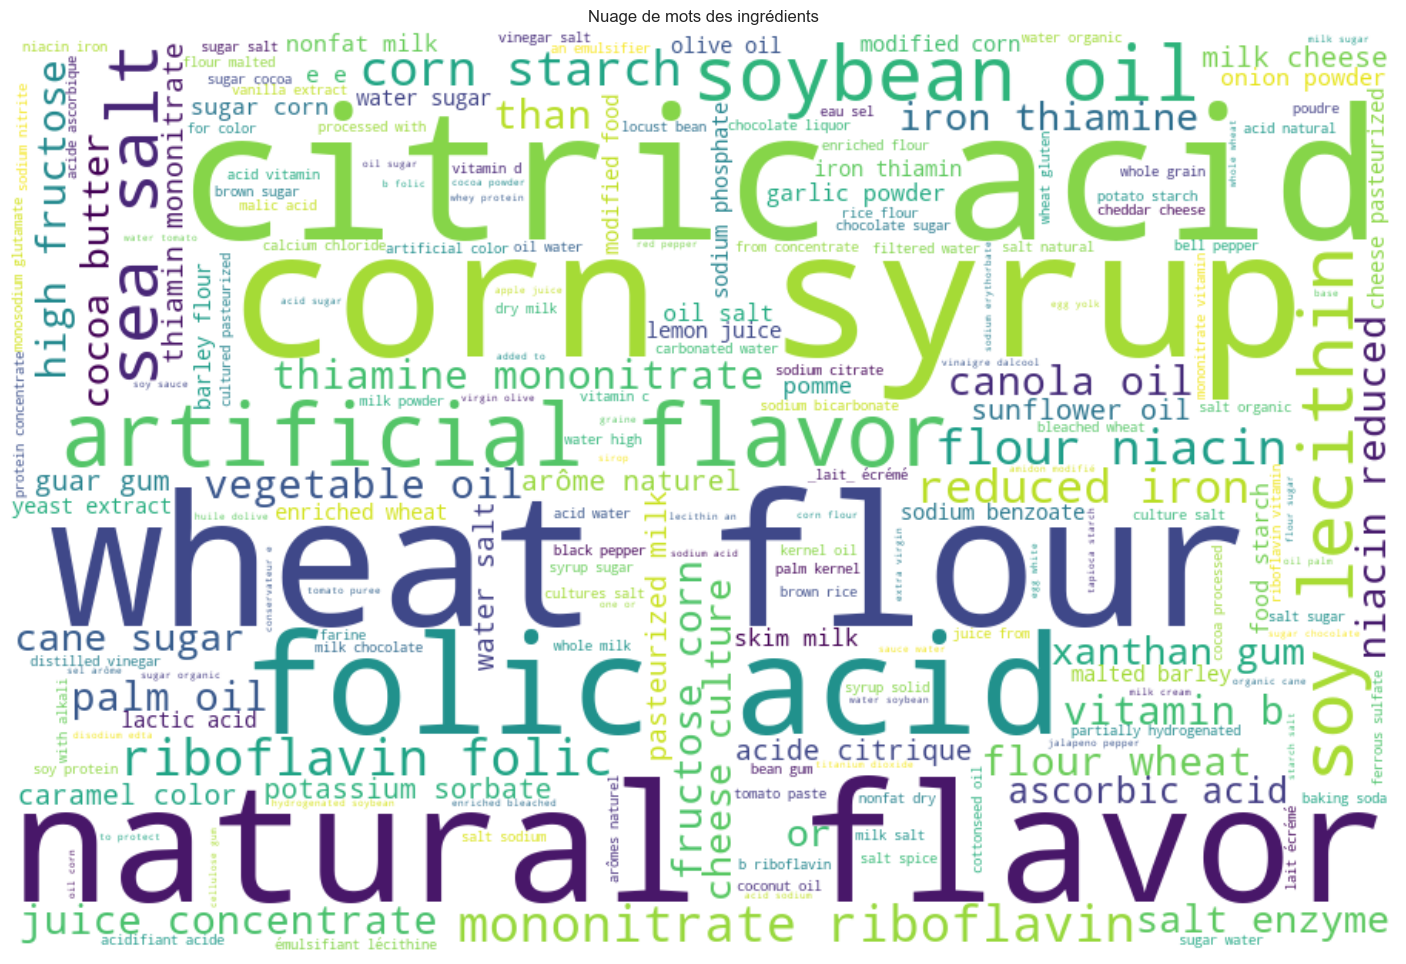

In [21]:
txt = ' '.join(data['ingredients_text'].astype(str).fillna(''))

tmp = DataSet.make_dataset(txt, 'txt')

wc = tmp.normalise().wordcloud(stopwords=STOPWORDS, width=900, height=600, max_font_size=120, background_color="white")

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots des ingrédients")
plt.show()

### Analyse de variables qualitatives

In [22]:
sns.set(rc={"figure.figsize":(10, 6)})

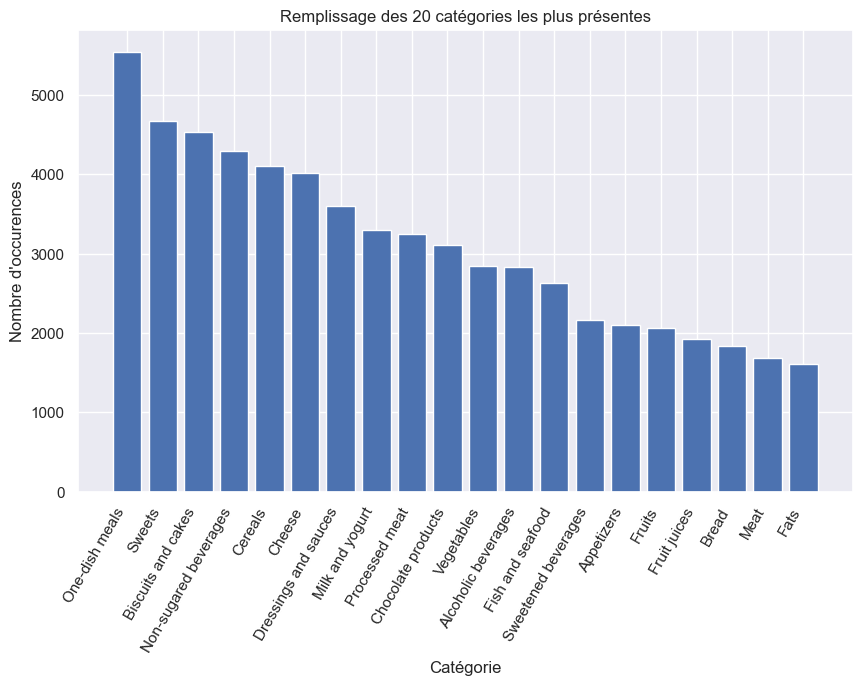

In [23]:
tmp = listeCatRemplissage[:20]

plt.bar(list(tmp.index), tmp.values)

plt.xticks(rotation=60, ha='right')

plt.title("Remplissage des {} catégories les plus présentes".format(len(tmp)))
plt.ylabel("Nombre d'occurences")
plt.xlabel("Catégorie")

plt.show()

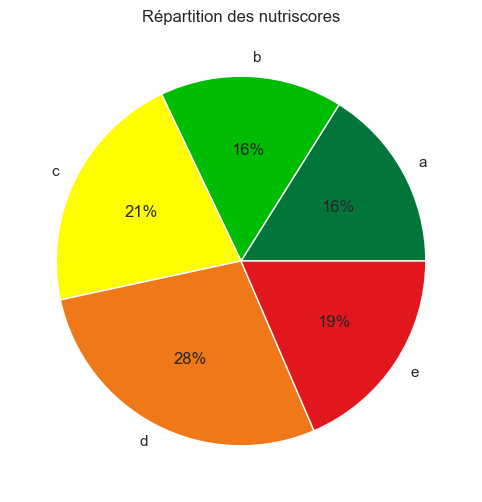

In [24]:
tmp = data['nutrition_grade_fr'].value_counts()

tmp = tmp.reindex(['a', 'b', 'c', 'd', 'e'])


palette_color = sns.color_palette('bright')

plt.pie(tmp.values, labels=tmp.index, colors=['#02753a', '#00bc02', '#fffe00', '#ef7819', '#e2161d'], autopct='%.0f%%')
plt.title("Répartition des nutriscores")
plt.show()

In [25]:
# Création de la liste des 20 additifs les plus présents
tmp = data['additives_tags'].str.split(',', expand = True).stack().str.replace('en:', '')

tmp = tmp.value_counts()[:20]

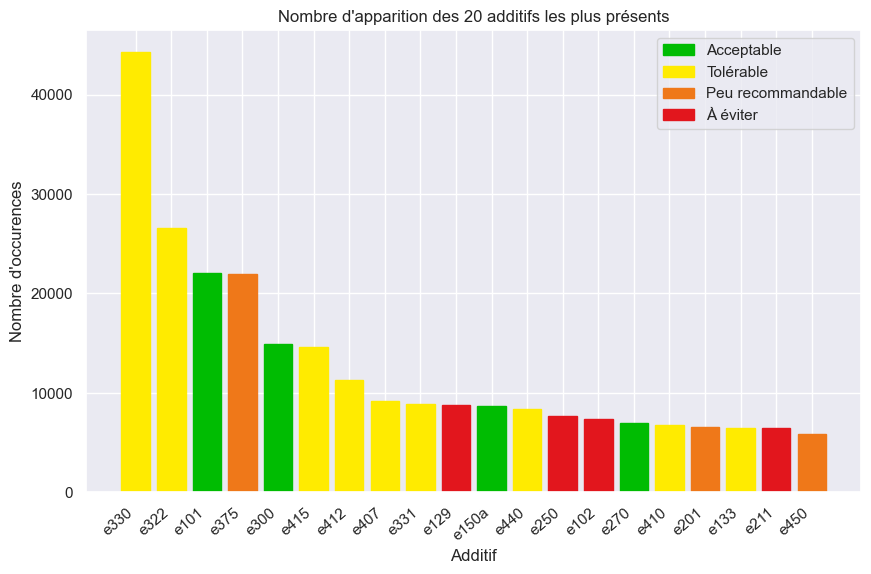

In [26]:
bars = plt.bar(list(tmp.index), tmp.values)

plt.xticks(rotation=40,ha='right')

couleurAdditifs = ['', '#00bc02', '#FFEB00', '#ef7819', '#e2161d']
for i, bar in enumerate(bars):
    a = tmp.index[i]
    if a not in listeAdditifs:
        a = 'e666'
    bar.set_color(couleurAdditifs[listeAdditifs[a]])

plt.title("Nombre d'apparition des {} additifs les plus présents".format(len(tmp)))
plt.ylabel("Nombre d'occurences")
plt.xlabel("Additif")

handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['#00bc02', '#FFEB00', '#ef7819', '#e2161d']]
plt.legend(handles, ['Acceptable', 'Tolérable', 'Peu recommandable', 'À éviter'])

plt.show()

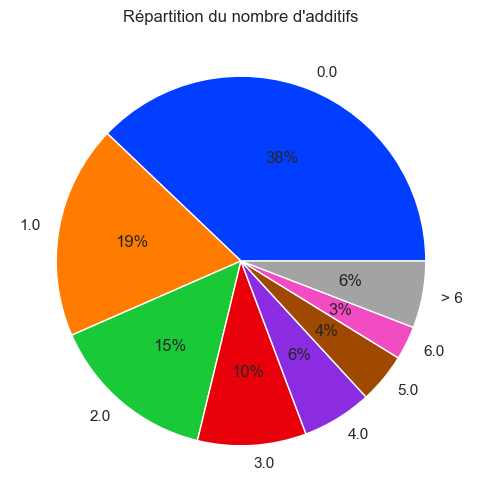

In [27]:
limit = 6

tmp = data['additives_n'].value_counts()

s = sum(tmp[limit+1:])
tmp = tmp[:limit]
tmp['> '+str(limit)] = s

palette_color = sns.color_palette('bright')

plt.pie(tmp.values, labels=tmp.index, colors=palette_color, autopct='%.0f%%')
plt.title("Répartition du nombre d'additifs")
plt.show()

### Analyse de variables quantitatives

In [28]:
sns.set(rc={"figure.figsize":(10, 20)})

In [29]:
# Liste des variables à analyser (energy n'est pas dedans pour rendre le graphique plus beau)
df = data[['fat_100g', 'saturated-fat_100g', 'omega-3-fat_100g',
'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 
'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g']]

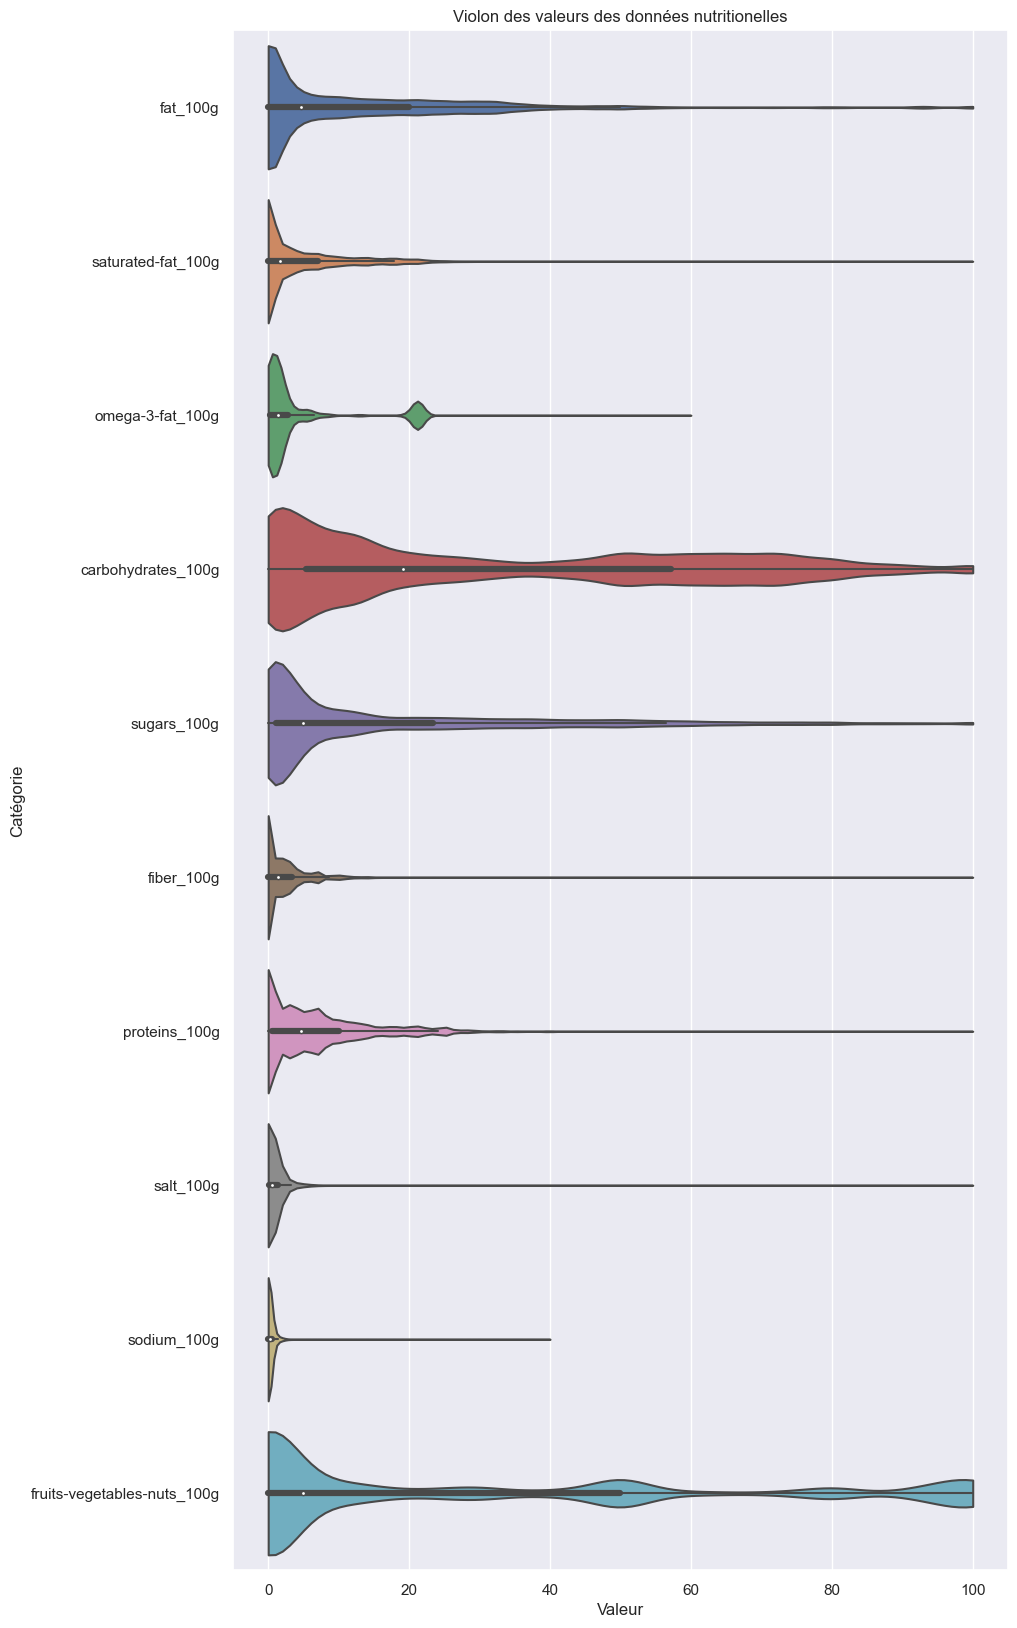

In [30]:
ax = sns.violinplot(data=df, orient='h', scale='width', cut=0)
ax.set(xlabel ="Valeur", ylabel = "Catégorie", title ='Violon des valeurs des données nutritionelles')
plt.show()

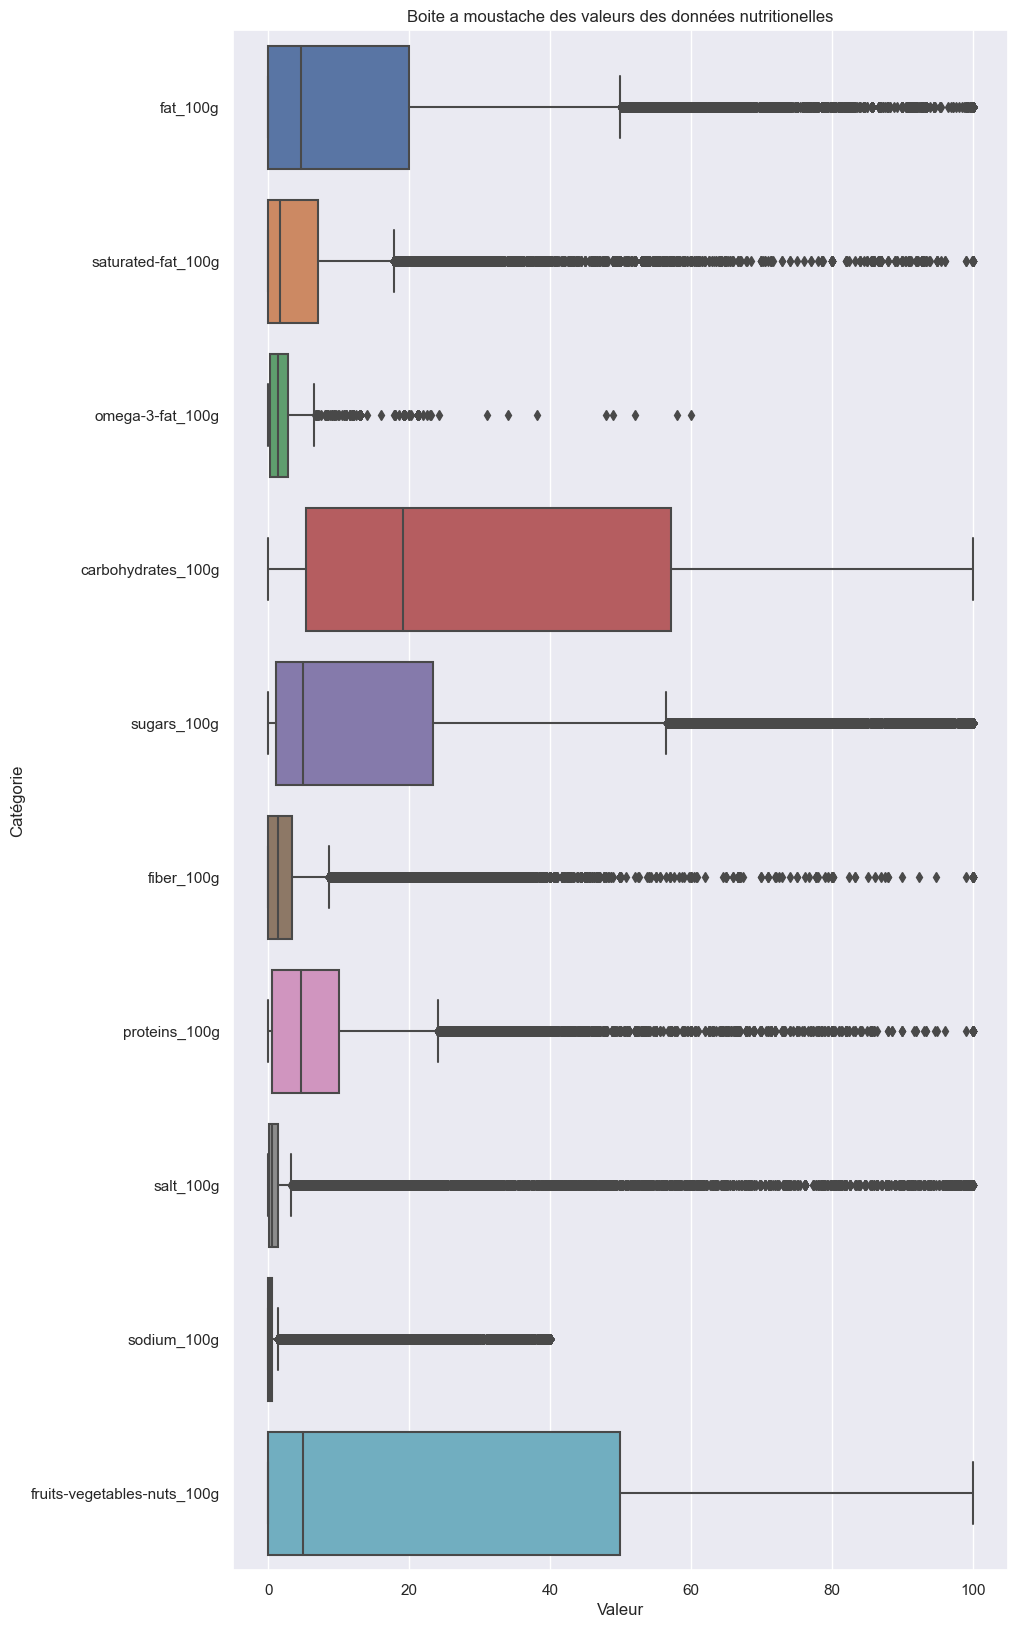

In [31]:
ax = sns.boxplot(data=df, orient='h')
ax.set(xlabel ="Valeur", ylabel = "Catégorie", title ='Boite a moustache des valeurs des données nutritionelles')
plt.show()

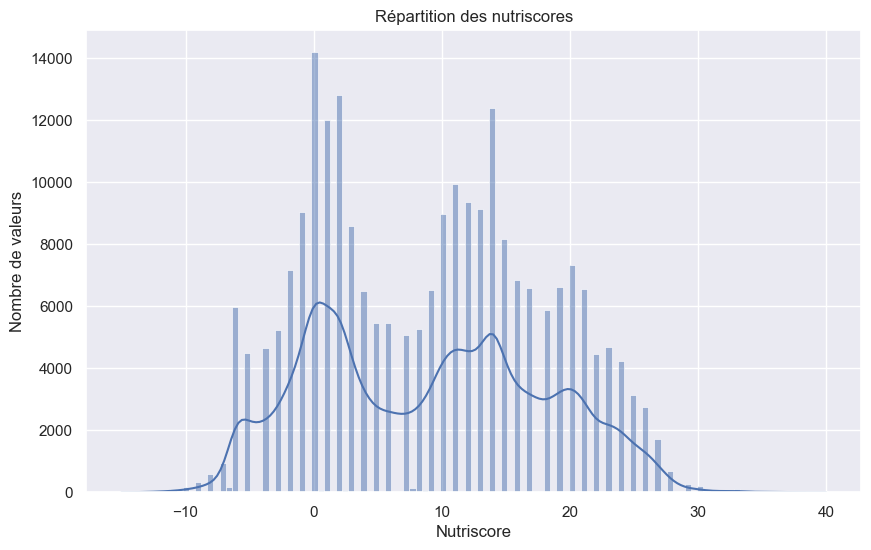

In [32]:
sns.set(rc={"figure.figsize":(10, 6)})
ax = sns.histplot(data=data['nutrition-score-fr_100g'], kde=True)
ax.set(xlabel ="Nutriscore", ylabel = "Nombre de valeurs", title ='Répartition des nutriscores')
plt.show()

## Analyses bivariées

### Graphiques interactifs pour les variables quantitatives

In [33]:
%matplotlib inline
sns.set(rc={"figure.figsize":(8, 6)})

In [34]:
@interact
def show_articles_more_than(x=widgets.Dropdown(options=listeColFloat, value='fat_100g'),
                            y=widgets.Dropdown(options=listeColFloat, value='saturated-fat_100g'), 
                            couleur=widgets.Dropdown(options=listeColFloat, value='energy_100g')):
    fig = plt.figure()
    ax = plt.axes()

    ax.scatter(data[x], data[y], c=data[couleur], alpha=0.3)

    ax.set_title('3d Scatter plot geeks for geeks')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.show()

interactive(children=(Dropdown(description='x', index=4, options=('additives_n', 'ingredients_from_palm_oil_n'…

In [35]:
# Création d'une liste de combinaison de variables interessantes à étudier
listeScatter = pd.DataFrame([['fat_100g', 'saturated-fat_100g', 'energy_100g', None],
                             ['carbohydrates_100g', 'sugars_100g', 'energy_100g', None],
                             ['fat_100g', 'proteins_100g', 'energy_100g', None],
                             ['fat_100g', 'proteins_100g', 'nutrition-score-fr_100g', None],
                             ['proteins_100g', 'carbohydrates_100g', 'nutrition-score-fr_100g', None],
                             ['fat_100g', 'carbohydrates_100g', 'nutrition-score-fr_100g', None],
                             ['salt_100g', 'sodium_100g', '', None],
                             ['nutrition-score-fr_100g', 'energy_100g', '', None]], columns=['x', 'y', 'c', 'title'])

listeScatter['title'] = listeScatter['x'] + ' * ' + listeScatter['y'] + ' - ' + listeScatter['c']

listeInteract = []

for i in listeScatter.index:
    listeInteract += [(listeScatter.loc[i, 'title'], i)]

In [36]:
@interact
def show_articles_more_than(graphique=widgets.Dropdown(options=listeInteract)):
    x = listeScatter.loc[graphique, 'x']
    y = listeScatter.loc[graphique, 'y']
    c = listeScatter.loc[graphique, 'c']
    if c != '':
        cNom = nomColonnes[c]
        c = data[c]
    else:
        cNom = ''
        c = 'b'
    t = listeScatter.loc[graphique, 'title']
    
    fig = plt.figure()
    ax = plt.axes()

    sc = ax.scatter(data[x], data[y], c=c, alpha=1)
    ax.scatter(data[x], data[y], c=c, alpha=0.3)

    ax.set_title(listeScatter.loc[graphique, 'title'])
    ax.set_xlabel(nomColonnes[x])
    ax.set_ylabel(nomColonnes[y])
    
    
    #legend
    if cNom != '':
        cb = fig.colorbar(sc, ax=ax)
        cb.set_label(cNom)
    
    
    plt.show()

interactive(children=(Dropdown(description='graphique', options=(('fat_100g * saturated-fat_100g - energy_100g…

In [37]:
%matplotlib notebook

<IPython.core.display.Javascript object>


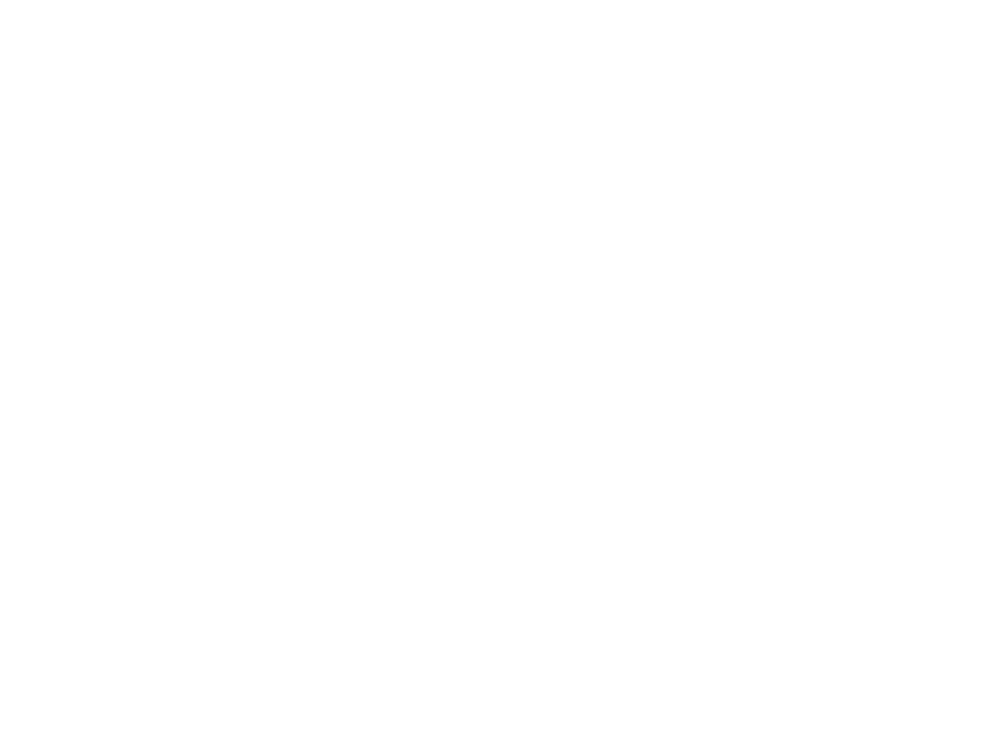

In [38]:
fig = plt.figure()
ax = plt.axes(projection="3d")

#energy_100g
sc = ax.scatter(data['fat_100g'], data['carbohydrates_100g'], data['proteins_100g'], c=data['nutrition-score-fr_100g'], alpha=1, s=0)
ax.scatter(data['fat_100g'], data['carbohydrates_100g'], data['proteins_100g'], c=data['nutrition-score-fr_100g'], alpha=0.1, s=7)

ax.set_title('3d Scatter plot geeks for geeks')
ax.set_xlabel('Lipides')
ax.set_ylabel('Glucides')
ax.set_zlabel('Proteines')

cb = fig.colorbar(sc, ax=ax)
cb.set_label('Nutriscore')

plt.show()

#### Heatmap pour toutes les variables quantitatives

In [39]:
%matplotlib inline

<AxesSubplot: >

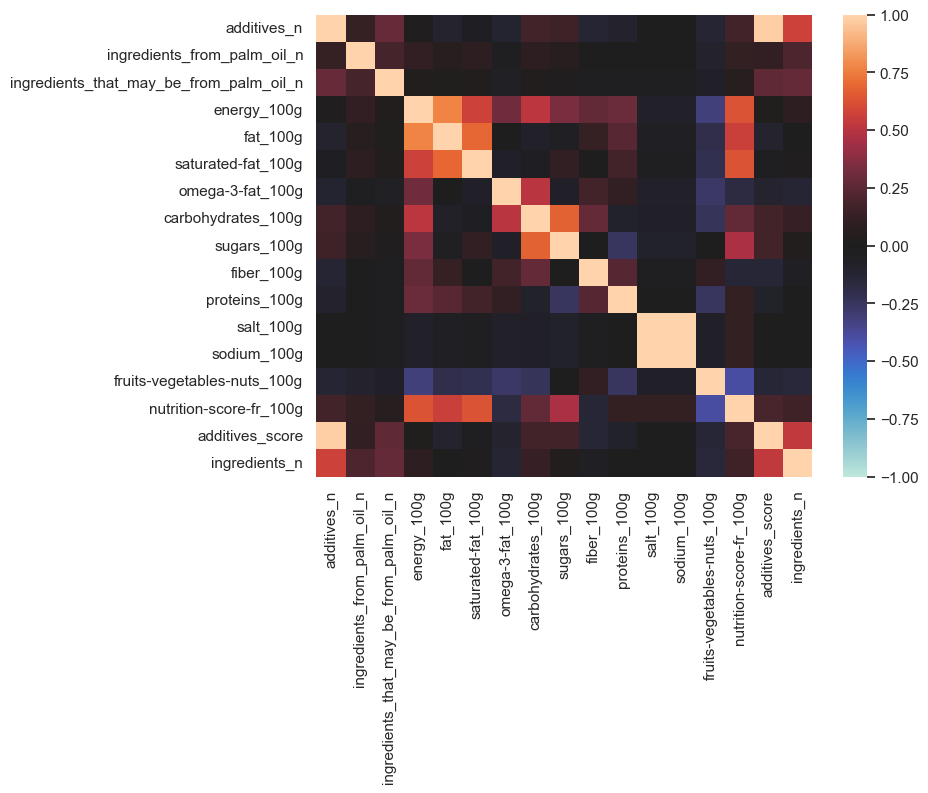

In [40]:
sns.heatmap(data[listeColFloat].corr(), vmin=-1, vmax=1, center=0)

#### Heatmap pour la totalitée des variables
avec donc conversion des variables qualitatives avec le LabelEncoder

In [41]:
listeColNonFloat = [c for c in data.columns if c not in listeColFloat]

In [42]:
dataTmp = data.copy()

In [43]:
label_encoder = LabelEncoder()

In [44]:
for c in [c for c in data.columns if c not in listeColFloat]:
    dataTmp[c] = label_encoder.fit_transform(dataTmp[c].astype(str))

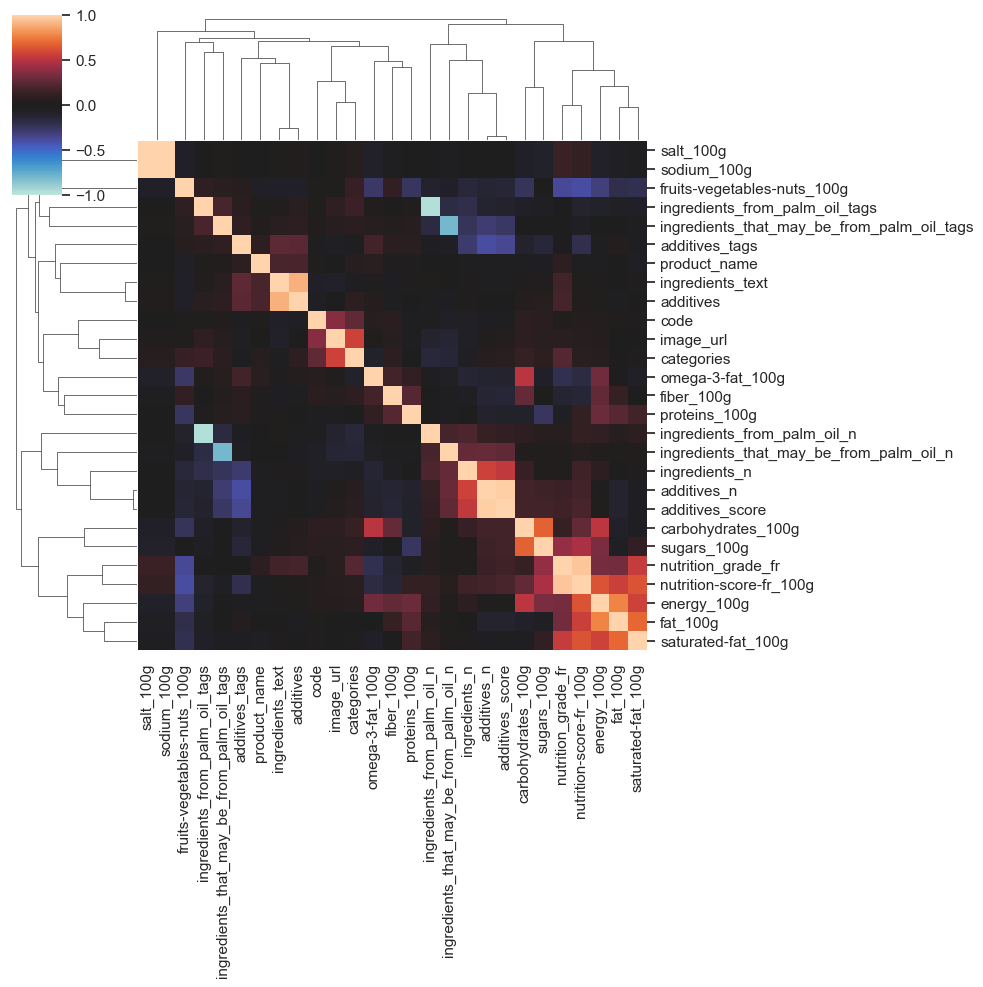

In [45]:
h = sns.clustermap(dataTmp.corr(), vmin=-1, vmax=1, center=0)

#### Extraction du dendrogram

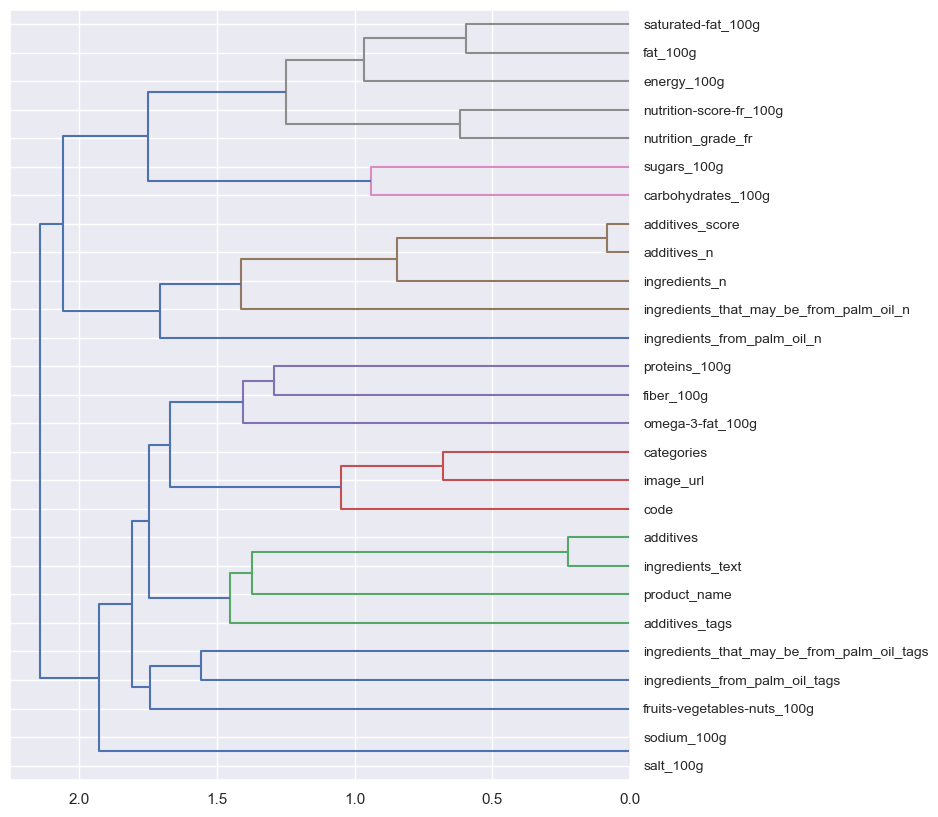

In [46]:
sns.set(rc={"figure.figsize":(8, 10)})
dendrogram(h.dendrogram_col.linkage, labels=dataTmp.columns, orientation='left');

### Analyse pour une variables quantitative et une autre qualitative

In [47]:
%matplotlib inline
sns.set(rc={"figure.figsize":(10, 12)})

In [48]:
nbVals = 15

In [49]:
# On ne garde que les lignes étant dans l'une des nbVals catégories les plus remplis
dataFrequent = data.loc[data["categories"].isin(listeCatRemplissage[:nbVals].index.to_list())]

In [50]:
@interact
def show_articles_more_than(x=widgets.Dropdown(options=listeColFloat, value='fat_100g')):
    #ax = sns.stripplot(data=dataFrequent, x=x, y="categories", hue="nutrition-score-fr_100g", orient='h', alpha=0.3)
    ax = sns.boxplot(data=dataFrequent, x=x, y="categories", orient='h')
    
    ax.set(xlabel=nomColonnes[x],
           ylabel='Catégorie',
           title='Boxplot des ' + nomColonnes[x] + ' pour les ' + str(nbVals) + ' catégories les plus fréquentes')
        
    listCat = [t.get_text()  for t in ax.get_yticklabels()]
    listTmp = []
    for n in listCat:
        nb = dataFrequent.loc[dataFrequent['categories']==n, x].notna().sum()
        listTmp += [(n, nb)]
    
    ax.set_yticklabels(["{} ({})".format(n, nb) for n, nb in listTmp])

    
    plt.show()

interactive(children=(Dropdown(description='x', index=4, options=('additives_n', 'ingredients_from_palm_oil_n'…

In [51]:
col = ['fat_100g','carbohydrates_100g','proteins_100g']

In [52]:
listCat = ['One-dish meals', 'Fish and seafood', 'Legumes', 'Dairy desserts', 'Cheese']

In [53]:
fig = go.Figure()


m = 0
for cat in listCat:
    val = data.loc[data['categories']==cat, col].median()
    m = max(m, val.max())
    fig.add_trace(go.Scatterpolar(
          r=val.values,
          theta=col,
          fill='toself',
          name=cat
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, m]
    )),
  showlegend=True
)


fig.show()

### Analyse pour deux variables qualitatives

In [54]:
sns.set(rc={"figure.figsize":(8, 6)})

In [55]:
y = 'additives_n'

In [56]:
tmp = data[[y, 'nutrition_grade_fr']].copy().dropna()

In [57]:
tmp[y] = pd.qcut(tmp[y], 6, duplicates='drop')

In [58]:
tmp['nutrition_grade_fr'] = pd.Categorical(tmp['nutrition_grade_fr'], ['a', 'b', 'c', 'd', 'e', 'f'])

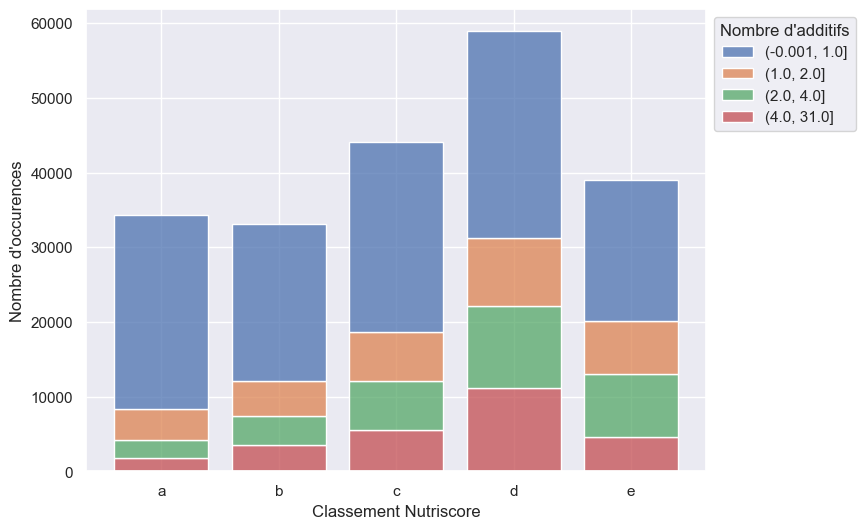

In [59]:
ax = sns.histplot(tmp, x='nutrition_grade_fr', hue=y,
             multiple='stack', shrink=0.8)

ax.set_xlabel(nomColonnes['nutrition_grade_fr'])
ax.set_ylabel("Nombre d'occurences")
    
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
legend.set_title(nomColonnes[y])

In [60]:
sns.set(rc={"figure.figsize":(8, 6)})

In [61]:
dataHeatmap = data.loc[data['categories'].isin(listeCatRemplissage[:10].index)]

In [62]:
dataHeatmap = dataHeatmap[['nutrition_grade_fr', 'categories']]

In [63]:
dataHeatmap['val'] = 1

In [64]:
dataHeatmap = dataHeatmap.pivot_table(values='val',index='categories',columns='nutrition_grade_fr',aggfunc=np.sum)

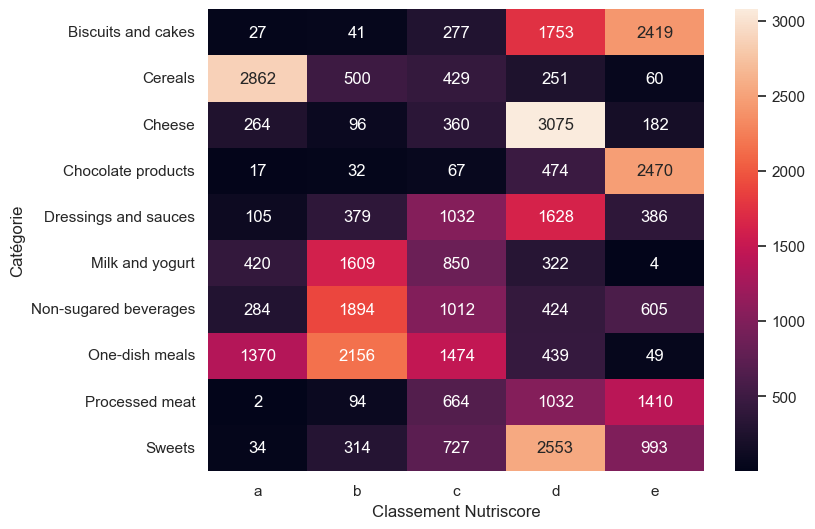

In [65]:
ax = sns.heatmap(dataHeatmap,annot=True, fmt='1.0f')

plt.xticks(rotation=0)
plt.yticks(rotation=0)

ax.set_xlabel(nomColonnes['nutrition_grade_fr'])
ax.set_ylabel(nomColonnes['categories'])

plt.show()

## ACP

In [66]:
sns.set(rc={"figure.figsize":(10, 6)})

In [67]:
scaler = StandardScaler()

In [68]:
listeColNum = listeColFloat.copy()

In [69]:
# Suppression de colonnes trop vides ou inutiles (trop proches d'autres colonnes, rendant donc le graphique moins lisible)
listeColNum.remove('sodium_100g')
#listeColNum.remove('sugars_100g')
listeColNum.remove('omega-3-fat_100g')
#listeColNum.remove('saturated-fat_100g')
listeColNum.remove('additives_n')
listeColNum.remove('ingredients_from_palm_oil_n')
listeColNum.remove('ingredients_that_may_be_from_palm_oil_n')
listeColNum.remove('fruits-vegetables-nuts_100g')

In [70]:
dataPCA = data[listeColNum + ['product_name']].copy()
dataPCA['product_name'] = dataPCA['product_name'].fillna('NaN')

In [71]:
nbTmp = len(dataPCA)
dataPCA = dataPCA.dropna()
print("On a enlevé {:0.2f}% de lignes. Il en reste {}".format(100*(nbTmp - len(dataPCA))/nbTmp, len(dataPCA)))

On a enlevé 36.41% de lignes. Il en reste 202003


In [72]:
dataPCANoms = dataPCA['product_name'].fillna('NaN')
dataPCA = dataPCA.drop('product_name', axis=1)

In [73]:
# dataPCA = SimpleImputer(missing_values=np.nan, strategy='mean').fit(dataPCA).transform(dataPCA)

In [74]:
X_scaled = scaler.fit_transform(dataPCA)

In [75]:
pd.DataFrame(X_scaled).describe().round(2)

0          1          2          3          4          5   \
count  202003.00  202003.00  202003.00  202003.00  202003.00  202003.00   
mean        0.00       0.00       0.00      -0.00       0.00      -0.00   
std         1.00       1.00       1.00       1.00       1.00       1.00   
min        -1.53      -0.82      -0.66      -1.15      -0.75      -0.64   
25%        -0.94      -0.78      -0.66      -0.91      -0.69      -0.64   
50%         0.02      -0.40      -0.43      -0.34      -0.50      -0.28   
75%         0.70       0.52       0.31       0.90       0.41       0.22   
max         3.45       5.44      13.28       2.38       4.38      23.41   

              6          7          8          9          10  
count  202003.00  202003.00  202003.00  202003.00  202003.00  
mean        0.00       0.00      -0.00       0.00      -0.00  
std         1.00       1.00       1.00       1.00       1.00  
min        -0.97      -0.29      -2.65      -0.72      -1.09  
25%        -0.75      -0.27      -0.88      -0.72      -0.70  
50%        -0.27      -0.14       0.01      -0.38      -0.14  
75%         0.38       0.03       0.79       0.31       0.30  
max        11.60      23.24       3.46      12.00      21.81

In [76]:
n_components = 6

In [77]:
pca = PCA(n_components=n_components)

In [78]:
pca.fit(X_scaled)

PCA(n_components=6)

In [79]:
(pca.explained_variance_ratio_*100).round(2)

array([29.83, 18.39, 13.89, 11.17,  9.18,  6.04])

In [80]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = listeColNum
pcs.index = [f"F{i}" for i in range(1, n_components+1)]


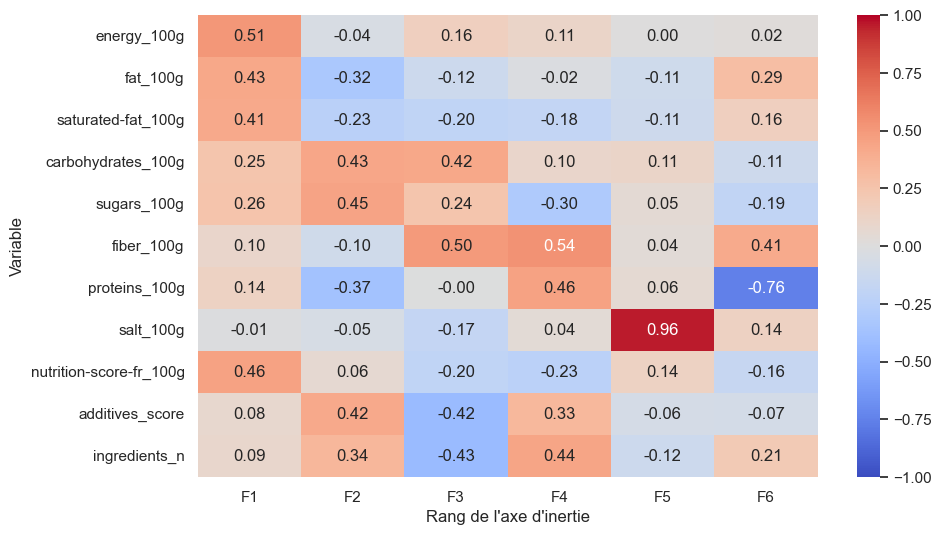

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

ax.set_xlabel("Rang de l'axe d'inertie")
ax.set_ylabel("Variable")
plt.show()

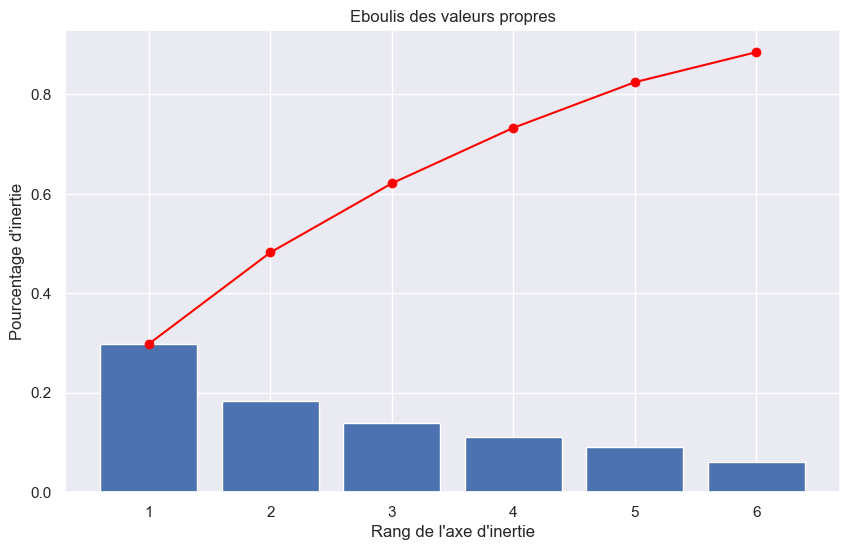

In [82]:
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(),c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [83]:
x, y = 0,1
#x, y = 2,3

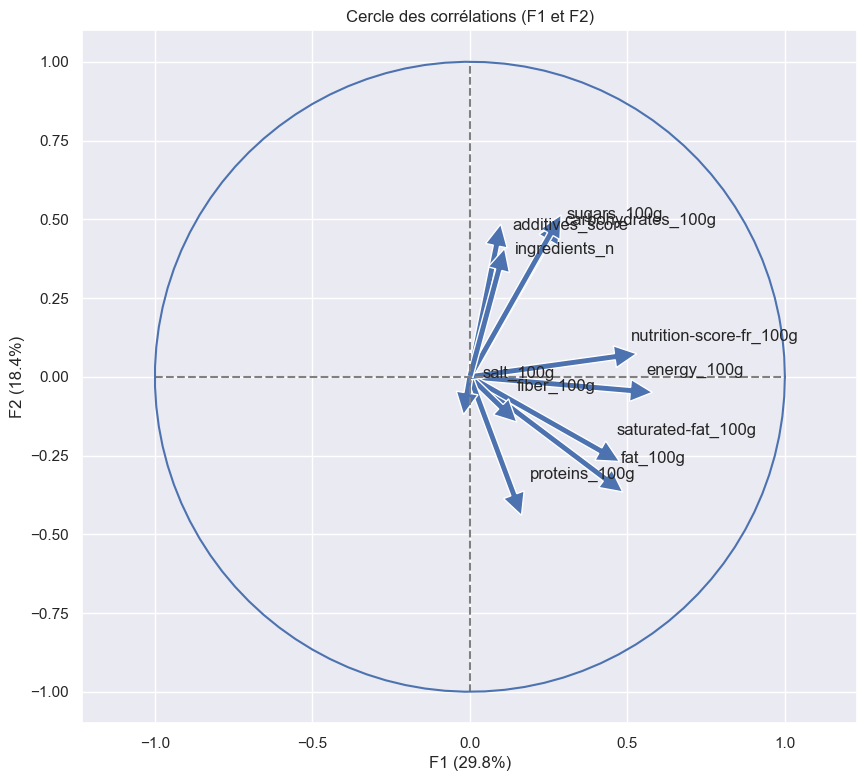

In [84]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[x, i],  #0 for PC1
             pca.components_[y, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[x, i] + 0.05,
             pca.components_[y, i] + 0.05,
             listeColNum[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

In [85]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                s=10,
                                figsize=[10,8], 
                                marker="."):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, alpha=alpha, s=s)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

In [86]:
X_proj = pca.transform(X_scaled)

In [87]:
x_y = [0, 1]
#x_y = [2, 3]

@interact
def show_articles_more_than(x=widgets.Dropdown(options=listeColFloat, value='fat_100g')):
    
    display_factorial_planes(X_proj, x_y, clusters=dataPCA[x], alpha=0.3, s=4)

interactive(children=(Dropdown(description='x', index=4, options=('additives_n', 'ingredients_from_palm_oil_n'…

In [88]:
listRandom = random.sample(range(len(dataPCA)), 50)

@interact#_manual
def show_articles_more_than(nb=(0,30), resample=False):
    if resample:
        global listRandom
        listRandom = random.sample(range(len(data)), 50)
        
    r = listRandom[:nb]
    tmp = dataPCANoms.iloc[r].values
    display_factorial_planes(X_proj[r], x_y, pca, figsize=(15,11), labels=tmp, marker="o", s=100)

interactive(children=(IntSlider(value=15, description='nb', max=30), Checkbox(value=False, description='resamp…

## ANOVA

In [89]:
dataANOVA = data[['additives_n', 'categories', 'nutrition-score-fr_100g', 'salt_100g']].copy()

In [90]:
# Fausses valeurs pour nombre d'additifs
#dataANOVA['additives_n'] = [max(0, int(random.gauss(2, 5))) for _ in range(len(dataANOVA))]

In [91]:
# Fausses valeurs pour nutriscore
#dataANOVA['nutrition-score-fr_100g'] = [max(-14, int(random.gauss(0, 10))) for _ in range(len(dataANOVA))]

In [92]:
dataANOVA = dataANOVA.dropna()
dataANOVA['additives_n'] = pd.qcut(dataANOVA['additives_n'], 8, duplicates='drop')
dataANOVA = dataANOVA.loc[dataANOVA['categories'].isin(dataANOVA['categories'].value_counts()[:6].index)]
dataANOVA['nutriscore'] = dataANOVA['nutrition-score-fr_100g']

In [93]:
Y, x1, x2 = 'nutrition-score-fr_100g', 'additives_n', 'categories'

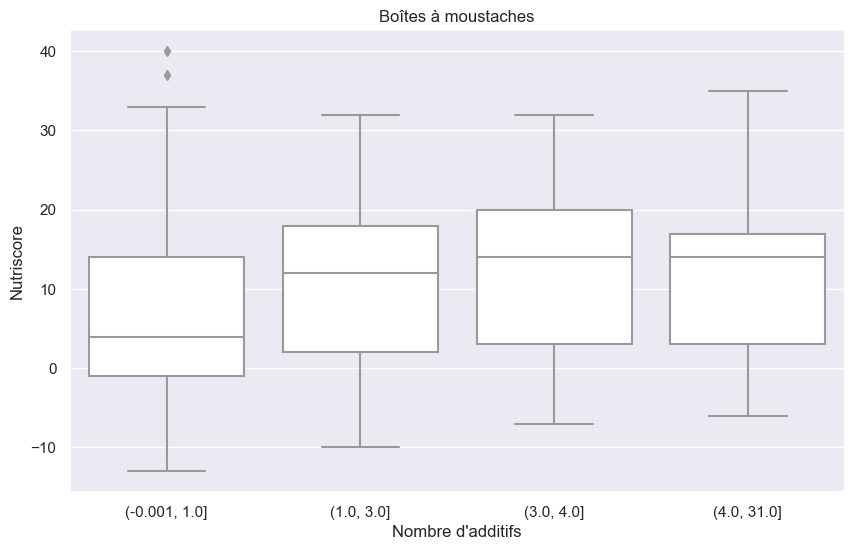

In [94]:
ax = sns.boxplot(x=x1, y=Y, data=dataANOVA, color='white')
plt.xlabel(nomColonnes[x1])
plt.ylabel(nomColonnes[Y])
plt.title('Boîtes à moustaches')
plt.show()

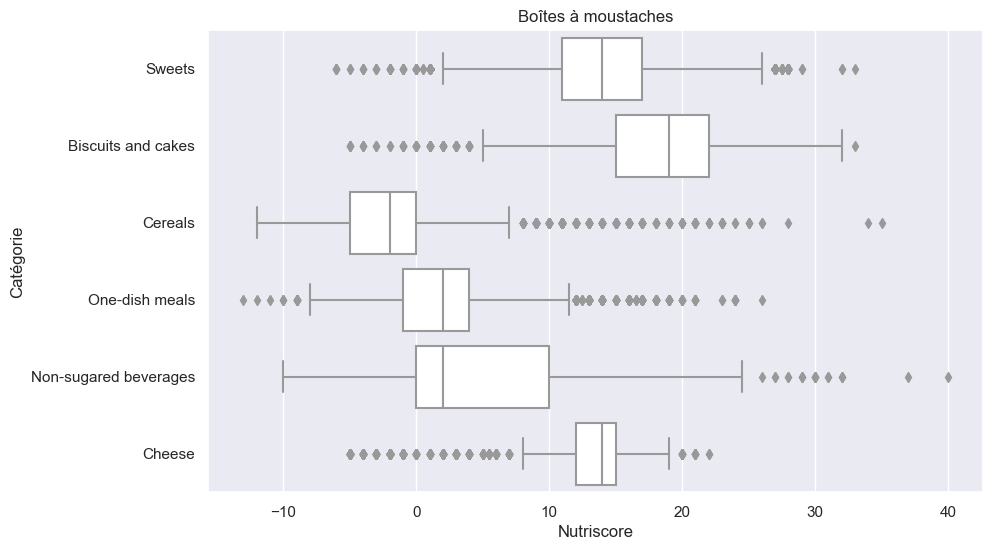

In [95]:
ax = sns.boxplot(x=Y, y=x2, data=dataANOVA, color='white', orient='h')
plt.ylabel(nomColonnes[x2])
plt.xticks(rotation=0)
plt.xlabel(nomColonnes[Y])
plt.title('Boîtes à moustaches')
plt.show()

In [96]:
Ytmp = y
if Y == 'nutrition-score-fr_100g':
    Ytmp = 'nutriscore'

anova_variete_phyto = smf.ols('{}~{}*{}'.format(Ytmp, x1, x2), data=dataANOVA).fit()
#print(anova_variete_phyto.summary())
sm.stats.anova_lm(anova_variete_phyto)

df         sum_sq        mean_sq            F  \
additives_n                 3.0  126142.007800   42047.335933  1348.757678   
categories                  5.0  969899.291326  193979.858265  6222.316287   
additives_n:categories     15.0   30430.456450    2028.697097    65.074772   
Residual                22379.0  697662.260761      31.174863          NaN   

                               PR(>F)  
additives_n              0.000000e+00  
categories               0.000000e+00  
additives_n:categories  4.164487e-194  
Residual                          NaN